In [2]:
# Packages
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
#import Keras
import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils import np_utils
from tensorflow.keras.layers import LSTM
from sklearn.model_selection import KFold, cross_val_score, train_test_split

Using TensorFlow backend.


In [6]:
#Import dataset
dtrain = pd.read_csv('train.csv', parse_dates = ['Date'], low_memory = False)
dtrain.head()
#given daily data and need to estimate number of sales

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


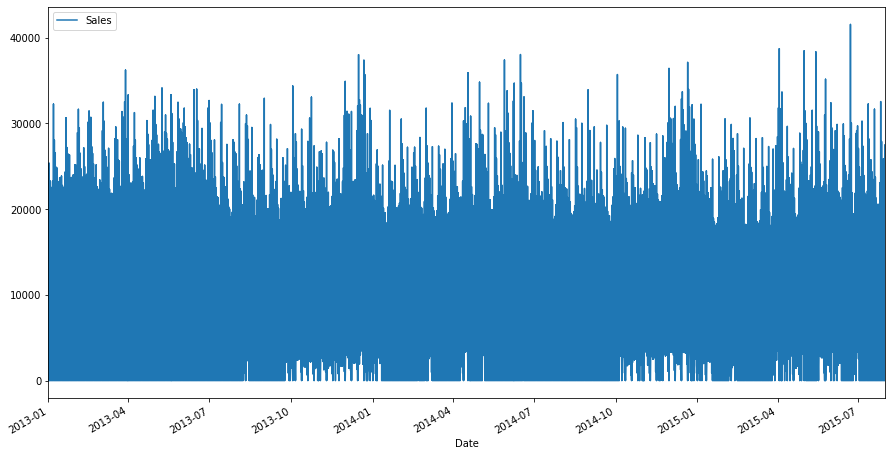

In [17]:
dtrain[['Date','Sales']].plot('Date', figsize=(15,8))
# consistent trend with seasonal variations
# non-stationary

In [7]:
dtrain.dtypes

Store                     int64
DayOfWeek                 int64
Date             datetime64[ns]
Sales                     int64
Customers                 int64
Open                      int64
Promo                     int64
StateHoliday             object
SchoolHoliday             int64
dtype: object

In [8]:
#Date range for training data
dtrain['Date'].min(), dtrain['Date'].max()

(Timestamp('2013-01-01 00:00:00'), Timestamp('2015-07-31 00:00:00'))

In [9]:
#ways to make series stationary
#Aggregate weekly sales (Aggregating dataset at weekly basis)
#Limits trend by taking average for a time period like monthly/weekly averages
dtrain.index = pd.to_datetime(dtrain['Date'])
dtsales = dtrain.resample('W').Sales.sum().reset_index()

In [10]:
dtsales

,Date,Sales
0,2013-01-06,26129335
1,2013-01-13,49275222
2,2013-01-20,34377765
3,2013-01-27,46040169
4,2013-02-03,38466029
...,...,...
130,2015-07-05,55690481
131,2015-07-12,41391282
132,2015-07-19,52008419
133,2015-07-26,39402115


In [12]:
dtsales.dtypes

Date     datetime64[ns]
Sales             int64
dtype: object

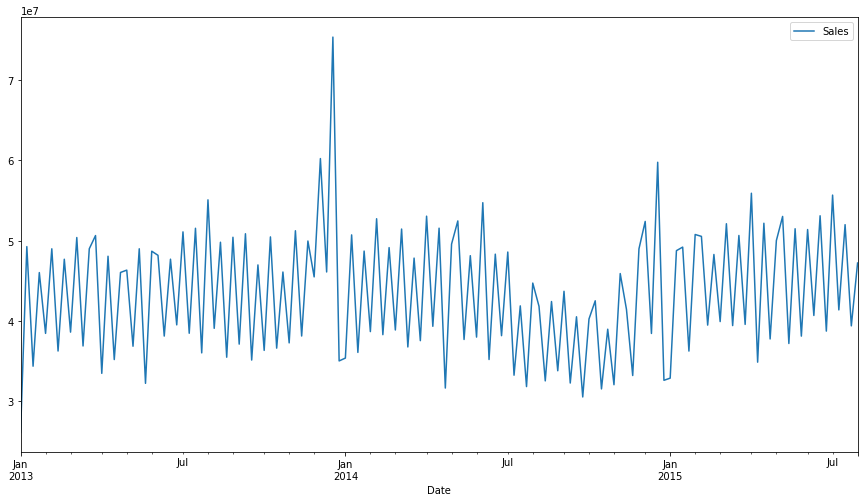

In [14]:
dtsales[['Date','Sales']].plot('Date', figsize=(15,8))
# do not appear to be any obvious outliers.
# huge spikes in December
# The seasonality suggests that the series is almost certainly non-stationary.

In [32]:
#Creating train and test set 
#Index 6 marks 6 weeks
train = dtsales[0:-6] 
test = dtsales[-6:]

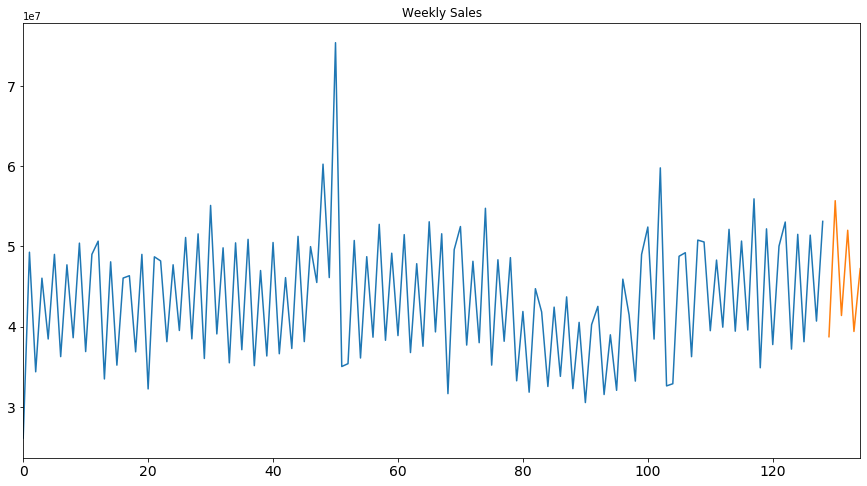

In [33]:
# Visualizing train and test
#Plotting data
train.Sales.plot(figsize=(15,8), title= 'Weekly Sales', fontsize=14)
test.Sales.plot(figsize=(15,8), title= 'Weekly Sales', fontsize=14)
plt.show()

In [19]:
#create a new dataframe to model the difference
dtdiff = dtsales.copy()

#add previous sales to the next row
dtdiff['prevsales'] = dtdiff['Sales'].shift(1)

#drop the null values and calculate the difference
dtdiff = dtdiff.dropna()
dtdiff['diff'] = (dtdiff['Sales'] - dtdiff['prevsales'])
dtdiff.head(10)

,Date,Sales,prevsales,diff
1,2013-01-13,49275222,26129335.0,23145887.0
2,2013-01-20,34377765,49275222.0,-14897457.0
3,2013-01-27,46040169,34377765.0,11662404.0
4,2013-02-03,38466029,46040169.0,-7574140.0
5,2013-02-10,49002283,38466029.0,10536254.0
6,2013-02-17,36269664,49002283.0,-12732619.0
7,2013-02-24,47701937,36269664.0,11432273.0
8,2013-03-03,38622888,47701937.0,-9079049.0
9,2013-03-10,50405423,38622888.0,11782535.0
10,2013-03-17,36897264,50405423.0,-13508159.0


In [20]:
#create dataframe for transformation from time series to supervised
dtsupervised = dtdiff.drop(['prevsales'],axis=1)

#look-back period = 52 weeks (1 calander year)
#adding lags
for inc in range(1,53):
    field_name = 'lag_' + str(inc)
    dtsupervised[field_name] = dtsupervised['diff'].shift(inc)

#drop null values
dtsupervised = dtsupervised.dropna().reset_index(drop=True)

In [21]:
dtsupervised

,Date,Sales,diff,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_43,lag_44,lag_45,lag_46,lag_47,lag_48,lag_49,lag_50,lag_51,lag_52
0,2014-01-12,50734135,15342055.0,356345.0,-40335594.0,29256108.0,-14126023.0,14737337.0,-4467851.0,11833289.0,...,-13508159.0,11782535.0,-9079049.0,11432273.0,-12732619.0,10536254.0,-7574140.0,11662404.0,-14897457.0,23145887.0
1,2014-01-19,36096897,-14637238.0,15342055.0,356345.0,-40335594.0,29256108.0,-14126023.0,14737337.0,-4467851.0,...,12110121.0,-13508159.0,11782535.0,-9079049.0,11432273.0,-12732619.0,10536254.0,-7574140.0,11662404.0,-14897457.0
2,2014-01-26,48718047,12621150.0,-14637238.0,15342055.0,356345.0,-40335594.0,29256108.0,-14126023.0,14737337.0,...,1644102.0,12110121.0,-13508159.0,11782535.0,-9079049.0,11432273.0,-12732619.0,10536254.0,-7574140.0,11662404.0
3,2014-02-02,38687737,-10030310.0,12621150.0,-14637238.0,15342055.0,356345.0,-40335594.0,29256108.0,-14126023.0,...,-17163595.0,1644102.0,12110121.0,-13508159.0,11782535.0,-9079049.0,11432273.0,-12732619.0,10536254.0,-7574140.0
4,2014-02-09,52745712,14057975.0,-10030310.0,12621150.0,-14637238.0,15342055.0,356345.0,-40335594.0,29256108.0,...,14588690.0,-17163595.0,1644102.0,12110121.0,-13508159.0,11782535.0,-9079049.0,11432273.0,-12732619.0,10536254.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,2015-07-05,55690481,16940713.0,-14365677.0,12418627.0,-10703920.0,13275337.0,-13375222.0,14294492.0,-15827189.0,...,9898813.0,-8622866.0,9883493.0,-9285721.0,-2896262.0,12893425.0,-10053739.0,8635250.0,-15342084.0,10418015.0
78,2015-07-12,41391282,-14299199.0,16940713.0,-14365677.0,12418627.0,-10703920.0,13275337.0,-13375222.0,14294492.0,...,-11427293.0,9898813.0,-8622866.0,9883493.0,-9285721.0,-2896262.0,12893425.0,-10053739.0,8635250.0,-15342084.0
79,2015-07-19,52008419,10617137.0,-14299199.0,16940713.0,-14365677.0,12418627.0,-10703920.0,13275337.0,-13375222.0,...,8252945.0,-11427293.0,9898813.0,-8622866.0,9883493.0,-9285721.0,-2896262.0,12893425.0,-10053739.0,8635250.0
80,2015-07-26,39402115,-12606304.0,10617137.0,-14299199.0,16940713.0,-14365677.0,12418627.0,-10703920.0,13275337.0,...,-9988089.0,8252945.0,-11427293.0,9898813.0,-8622866.0,9883493.0,-9285721.0,-2896262.0,12893425.0,-10053739.0


In [22]:
#How useful are our features for prediction?

import statsmodels.formula.api as smf

# Define the regression formula
model = smf.ols(formula='diff ~ lag_1', data=dtsupervised)

# Fit the regression
model_fit = model.fit()

# Extract the adjusted r-squared
regression_adj_rsq = model_fit.rsquared_adj
print(regression_adj_rsq)

#lag_1 explains 66% of the variation.

0.6568543572552858


In [23]:
# Define the regression formula
model = smf.ols(formula='diff ~ lag_1 + lag_2 + lag_3 + lag_4 + lag_5 + lag_6 + lag_7 + lag_8 + lag_9 + lag_10 + lag_11 + lag_12 + lag_13 + lag_14 + lag_15 + lag_16 + lag_17 + lag_18 + lag_19 + lag_20 + lag_21 + lag_22 + lag_23 + lag_24 + lag_25 + lag_26 + lag_27 + lag_28 + lag_29 + lag_30 + lag_31 + lag_32 + lag_33 + lag_34 + lag_35 + lag_36 + lag_37 + lag_38 + lag_39 + lag_40 + lag_41 + lag_42 + lag_43 + lag_44 + lag_45 + lag_46 + lag_47 + lag_48 + lag_49 + lag_50 + lag_51 + lag_52', data=dtsupervised)

# Fit the regression
model_fit = model.fit()

# Extract the adjusted r-squared
regression_adj_rsq = model_fit.rsquared_adj
print(regression_adj_rsq)

#Entire feature set explains 83% of variation

0.8251934262315428


In [24]:
#import MinMaxScaler and create a new dataframe for LSTM model
from sklearn.preprocessing import MinMaxScaler
dfmodel = dtsupervised.drop(['Sales','Date'],axis=1)
dfmodel.head()

,diff,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,...,lag_43,lag_44,lag_45,lag_46,lag_47,lag_48,lag_49,lag_50,lag_51,lag_52
0,15342055.0,356345.0,-40335594.0,29256108.0,-14126023.0,14737337.0,-4467851.0,11833289.0,-13111489.0,13968054.0,...,-13508159.0,11782535.0,-9079049.0,11432273.0,-12732619.0,10536254.0,-7574140.0,11662404.0,-14897457.0,23145887.0
1,-14637238.0,15342055.0,356345.0,-40335594.0,29256108.0,-14126023.0,14737337.0,-4467851.0,11833289.0,-13111489.0,...,12110121.0,-13508159.0,11782535.0,-9079049.0,11432273.0,-12732619.0,10536254.0,-7574140.0,11662404.0,-14897457.0
2,12621150.0,-14637238.0,15342055.0,356345.0,-40335594.0,29256108.0,-14126023.0,14737337.0,-4467851.0,11833289.0,...,1644102.0,12110121.0,-13508159.0,11782535.0,-9079049.0,11432273.0,-12732619.0,10536254.0,-7574140.0,11662404.0
3,-10030310.0,12621150.0,-14637238.0,15342055.0,356345.0,-40335594.0,29256108.0,-14126023.0,14737337.0,-4467851.0,...,-17163595.0,1644102.0,12110121.0,-13508159.0,11782535.0,-9079049.0,11432273.0,-12732619.0,10536254.0,-7574140.0
4,14057975.0,-10030310.0,12621150.0,-14637238.0,15342055.0,356345.0,-40335594.0,29256108.0,-14126023.0,14737337.0,...,14588690.0,-17163595.0,1644102.0,12110121.0,-13508159.0,11782535.0,-9079049.0,11432273.0,-12732619.0,10536254.0


In [25]:
#split train and test set
#As the test set, we have selected the last 6 weeks’ sales.
train_set, test_set = dfmodel[0:-6].values, dfmodel[-6:].values

In [34]:
#apply Min Max Scaler
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(train_set)

# reshape training set
train_set = train_set.reshape(train_set.shape[0], train_set.shape[1])
train_set_scaled = scaler.transform(train_set)

# reshape test set
test_set = test_set.reshape(test_set.shape[0], test_set.shape[1])
test_set_scaled = scaler.transform(test_set)

In [35]:
# create feature and label sets from scaled datasets
X_train, y_train = train_set_scaled[:, 1:], train_set_scaled[:, 0:1]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test, y_test = test_set_scaled[:, 1:], test_set_scaled[:, 0:1]
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [36]:
#fit LSTM model
model = Sequential()
model.add(LSTM(4, batch_input_shape=(1, X_train.shape[1], X_train.shape[2]), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, nb_epoch=100, batch_size=1, verbose=1, shuffle=False)

Train on 76 samples
Epoch 1/100
76/76 [==============================] - 22s 292ms/sample - loss: 0.2800
Epoch 2/100
76/76 [==============================] - 1s 12ms/sample - loss: 0.2174
Epoch 3/100
76/76 [==============================] - 1s 13ms/sample - loss: 0.1742
Epoch 4/100
76/76 [==============================] - 1s 13ms/sample - loss: 0.1396
Epoch 5/100
76/76 [==============================] - 1s 14ms/sample - loss: 0.11400s - loss: 0.11
Epoch 6/100
76/76 [==============================] - 1s 15ms/sample - loss: 0.0961
Epoch 7/100
76/76 [==============================] - 1s 15ms/sample - loss: 0.0835
Epoch 8/100
76/76 [==============================] - 1s 15ms/sample - loss: 0.0738
Epoch 9/100
76/76 [==============================] - 1s 11ms/sample - loss: 0.0657
Epoch 10/100
76/76 [==============================] - 1s 12ms/sample - loss: 0.0588
Epoch 11/100
76/76 [==============================] - 1s 11ms/sample - loss: 0.0526
Epoch 12/100
76/76 [============================

76/76 [==============================] - 1s 9ms/sample - loss: 0.0014
Epoch 94/100
76/76 [==============================] - 1s 9ms/sample - loss: 0.0017
Epoch 95/100
76/76 [==============================] - 1s 9ms/sample - loss: 0.0019
Epoch 96/100
76/76 [==============================] - 1s 8ms/sample - loss: 0.0022
Epoch 97/100
76/76 [==============================] - 1s 8ms/sample - loss: 0.0024
Epoch 98/100
76/76 [==============================] - 1s 8ms/sample - loss: 0.0028
Epoch 99/100
76/76 [==============================] - 1s 8ms/sample - loss: 0.0029
Epoch 100/100
76/76 [==============================] - 1s 8ms/sample - loss: 0.0032


In [107]:
y_pred = model.predict(X_test,batch_size=1)

In [112]:
from keras.utils import np_utils
import warnings
warnings.filterwarnings("ignore")

In [114]:
# inverse transformation for scaling

#reshape y_pred
y_pred = y_pred.reshape(y_pred.shape[0], 1, y_pred.shape[1])

#rebuild test set for inverse transform
pred_test_set = []
for index in range(0,len(y_pred)):
    print(np.concatenate([y_pred[index],X_test[index]],axis=1))
    pred_test_set.append(np.concatenate([y_pred[index],X_test[index]],axis=1))

#reshape pred_test_set
pred_test_set = np.array(pred_test_set)
pred_test_set = pred_test_set.reshape(pred_test_set.shape[0], pred_test_set.shape[2])

#inverse transform
pred_test_set_inverted = scaler.inverse_transform(pred_test_set)

[[-0.34165636  0.63261736 -0.0388717   0.54072769 -0.22518429  0.57001724
  -0.29565151  0.24544912  0.51158542 -0.25503644  0.65654227 -0.4455545
   0.6287466  -0.15914616  0.48181724 -0.2054067   0.50945824 -0.08102696
   0.41205303 -0.158379    0.15245769  0.5765062  -0.21297536  0.17194392
   0.61553804  0.16697772 -0.62130902  0.77205564 -0.24184608  0.25736206
   0.61259255 -0.07761718  0.03109221  0.55712987 -0.03953632  0.37293978
  -0.15623383  0.22432815  0.43834835 -0.12784128  0.39638887 -0.16920264
   0.44368957 -0.08860605  0.44324928 -0.10765588  0.07597116  0.52975189
  -0.129728    0.40737595 -0.28171005  0.45861094 -0.13258362]]
[[ 0.64192653 -0.47227026  0.71112759 -0.14841359  0.54072769 -0.22518429
   0.57001724 -0.29565151  0.24544912  0.51158542 -0.25503644  0.65654227
  -0.4455545   0.6287466  -0.15914616  0.48181724 -0.2054067   0.50945824
  -0.08102696  0.41205303 -0.158379    0.15245769  0.5765062  -0.21297536
   0.17194392  0.61553804  0.16697772 -0.62130902

In [125]:
#create dataframe that shows the predicted sales
resultlist = []
salesdates = list(dtsales[-7:].Date)
actsales = list(dtsales[-7:].Sales)
for index in range(0,len(pred_test_set_inverted)):
    resultdict = {}
    resultdict['Date'] = salesdates[index+1]
    resultdict['PredictedValue'] = int(pred_test_set_inverted[index][0] + actsales[index])
    resultlist.append(resultdict)
dtresult = pd.DataFrame(resultlist)
dtresult

,Date,PredictedValue
0,2015-06-14,41916065
1,2015-06-21,51394064
2,2015-06-28,41730145
3,2015-07-05,53284907
4,2015-07-12,42780307
5,2015-07-19,53104872


In [128]:
#merge with actual sales dataframe
dtsalespred = pd.merge(dtsales, dtresult, on='Date', how='left')
dtsalespred.tail(6)

,Date,Sales,PredictedValue
0,2012-12-23,26129335,NaN
1,2012-12-30,49275222,NaN
2,2013-01-06,34377765,NaN
3,2013-01-13,46040169,NaN
4,2013-01-20,38466029,NaN
...,...,...,...
130,2015-06-21,55690481,51394064.0
131,2015-06-28,41391282,41730145.0
132,2015-07-05,52008419,53284907.0
133,2015-07-12,39402115,42780307.0


In [ ]:
# Accuracy
rms = sqrt(mean_squared_error(test.Sales, y_hat_avg.SARIMA))
print(rms)